In [1]:
import numpy as np
import scipy.integrate as sint
import random
import matplotlib.pyplot as plt


In [2]:
rho  = 1.0
beta = 0.0
alpha = 0.08
n = 3.0
N_steps = 100
T_max = 500
h = 0.1

In [3]:
def generate_random_initial_surface(Nsteps):
    list = [i * 1.0 for i in range(1, Nsteps + 1)]
    var = 0.2
    for i in range(Nsteps):
        list[i] = i - 1 + (1.0 - var) + random.uniform(0, 2.0 * var)
    list.sort()
    return np.array(list)

In [4]:
def velocity_mm1(t, Y):
    """
    The original fortran implenetation of the rhs of the IVP, "translated" directly to python
    """
    M = len(Y)
    DY = [0.0 for _ in range(M)]
    d = [0.0 for _ in range(M + 1)]
    d3 = [0.0 for _ in range(M + 1)]

    for i in range(1, M):
        dtemp = Y[i] - Y[i - 1]
        d[i] = dtemp ** rho
        d3[i] = 1.0 / (dtemp ** n)

    dtem = Y[0] - Y[M - 1] + M
    d[0] = dtem ** rho
    d[M] = d[0]
    d3[0] = 1.0 / (dtem ** n)
    d3[M] = d3[0]

    for i in range(M):
        DY[i] = d[i] + beta * d[i + 1] - alpha * (d3[i + 1] - d3[i])

    return np.array(DY)

In [5]:
def velocity_mm1_fast(t, Y):
    """
    Optimized version that works with vectorized numpy code and no for-loops. Significantly faster
    """ 
    M = len(Y)
    Y = np.array(Y)

    d = np.zeros(M + 1)
    d3 = np.zeros(M + 1)
    
    d[1:M] = np.diff(Y)**rho
    d3[1:M] = 1.0 / np.diff(Y)**n
    
    d[0] = (Y[0] - Y[-1] + M)**rho
    d[M] = d[0]
    d3[0] = 1.0 / (Y[0] - Y[-1] + M)**n
    d3[M] = d3[0]
    
    DY = d[:-1] + beta * d[1:] - alpha * (d3[1:] - d3[:-1])

    return DY


In [6]:
# Test if the "fast" and "slow" implementations are the same
test_surf = generate_random_initial_surface(10)
assert(np.linalg.norm(velocity_mm1(0, test_surf) - velocity_mm1_fast(0, test_surf)) < 1e-10) 

In [7]:
y0 = generate_random_initial_surface(N_steps)

In [8]:
odeprob = sint.ode(velocity_mm1_fast)
odeprob.set_integrator('vode', method='bdf', order=15, nsteps=3000)
odeprob.set_initial_value(y0)


In [9]:
ts = [0]
ys = [y0]

while odeprob.successful() and odeprob.t < T_max:
    ts.append(odeprob.t+h)
    ys.append(odeprob.integrate(odeprob.t+h))

ts = np.array(ts)
ys = np.array(ys)

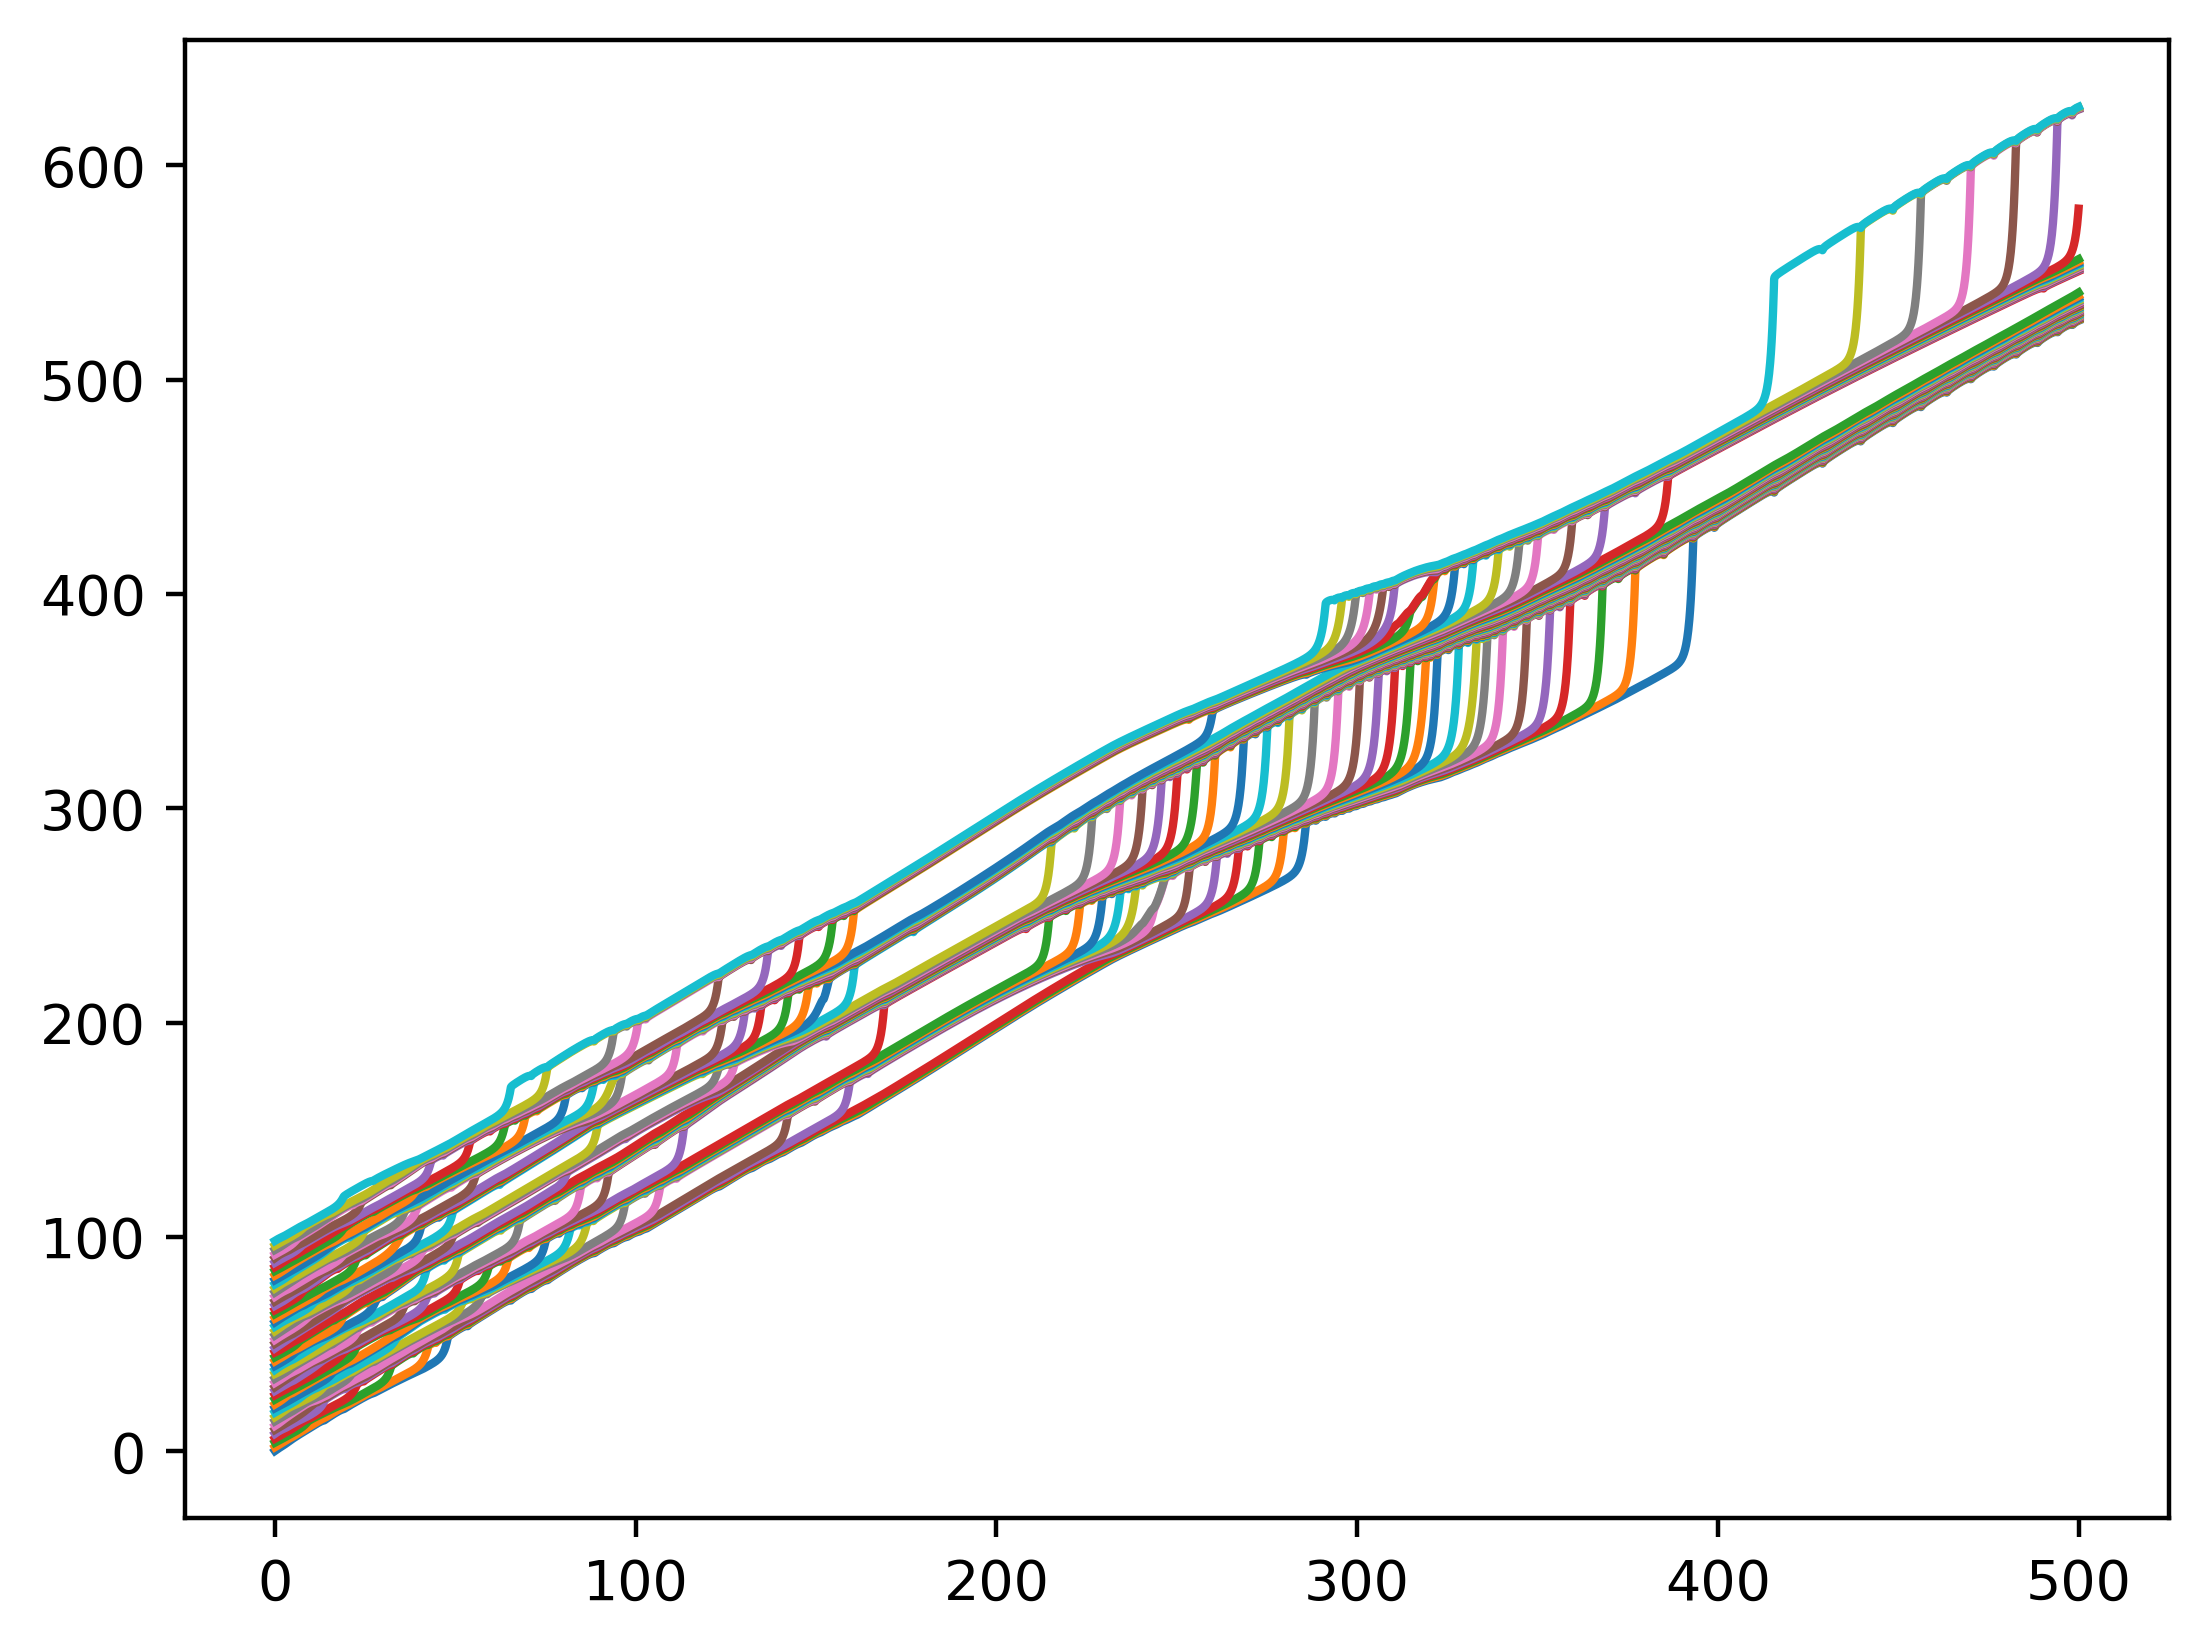

In [10]:
plt.rcParams['figure.dpi'] = 400 # set figure dpi

for i in range(0, N_steps, 2): # plot every second trajectory
    plt.plot(ts, ys[:,i])

plt.show()
